In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [20]:
torch.manual_seed(42)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [22]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.shape


(60000, 785)

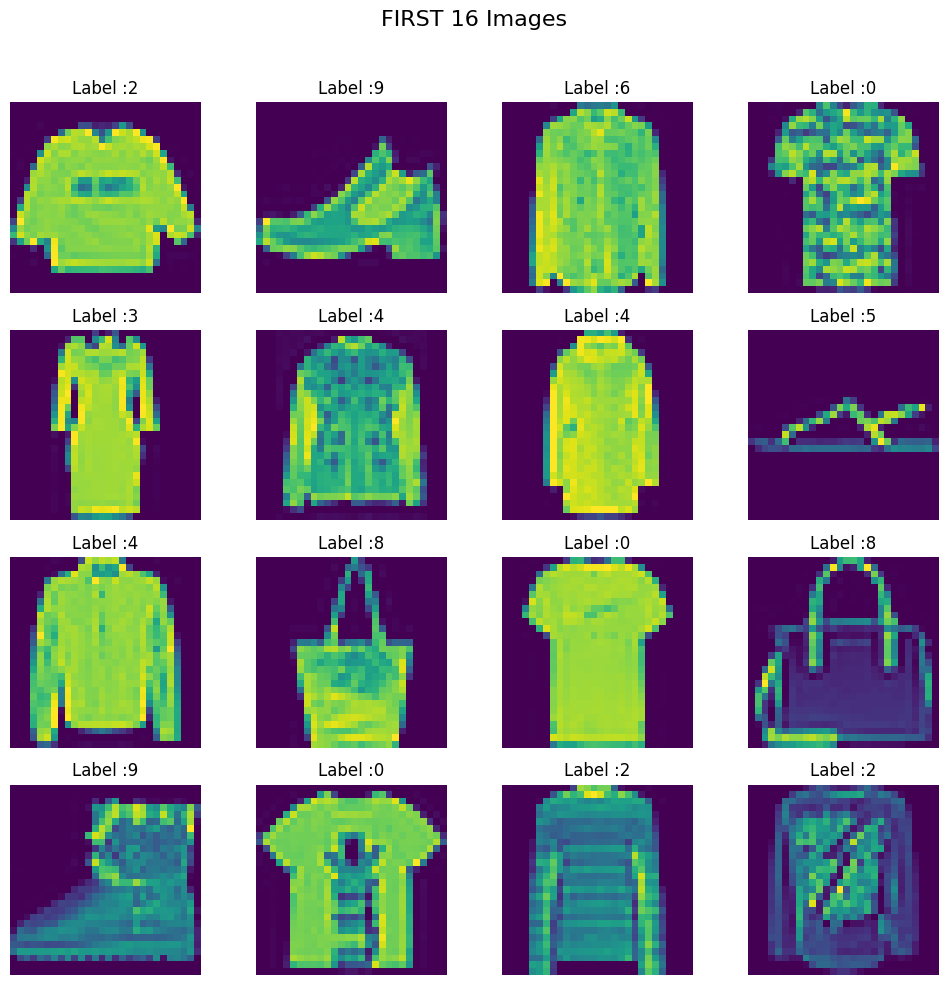

In [24]:
fig, axes = plt.subplots(4,4,figsize =(10,10))
fig.suptitle("FIRST 16 Images",fontsize = 16)

for i ,ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label :{df.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [25]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [27]:
X_train = X_train/255.0
X_test = X_test/255.0

In [48]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]



In [49]:
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [50]:
train_loader = DataLoader(train_dataset,batch_size =32,shuffle = True,pin_memory = True)
test_loader = DataLoader(test_dataset,batch_size= 32,shuffle = False,pin_memory=True)


In [51]:
len(train_loader)

1500

In [32]:
class MyNN(nn.Module):
  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer):
    super().__init__()
    layers = []
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer,output_dim))
    self.model = nn.Sequential(*layers) #UNPACKING AS Seq need INdividual layers instead of whole architecture at once

  def  forward(self,x):
    return self.model(x)




In [44]:
# OBJECTIVE
def objective(trial):
   # DEFINING SEARCH SPACE
   num_hidden_layers = trial.suggest_int("NUMBER OF HIDDEN LAYERS ",1,5)
   neurons_per_layer = trial.suggest_int("NEURONS PER LAYER ",8,128,step = 8)

   # MODEL INIT
   input_dim = 784
   output_dim = 10
   model = MyNN(input_dim,output_dim,num_hidden_layers,neurons_per_layer)
   model.to(device)
   # PARAMS INIT
   learning_rate = 0.01
   epochs = 100
   #optimizer
   criteria = nn.CrossEntropyLoss()
   optimizer = optim.SGD(model.parameters(),lr=learning_rate)
   # TRAINING LOOP
   for epoch in range(epochs):
     total_epoch_loss = 0
     for batch_features,batch_labels in train_loader:
          batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
          outputs = model(batch_features)
          loss = criteria(outputs,batch_labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
#EVALUATION
   model.eval()
   total = 0
   correct  = 0
   with torch.no_grad():
     for batch_features,batch_labels in test_loader:
       batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
       outputs = model(batch_features)
       _,predicted = torch.max(outputs,1)
       total = total + batch_labels.shape[0]
       correct = correct + (predicted == batch_labels).sum().item()
       accuracy = correct / total
     return accuracy

In [34]:
!pip install optuna

In [45]:
import optuna
study = optuna.create_study(direction='maximize')

[I 2025-06-08 15:59:21,568] A new study created in memory with name: no-name-521e8fa5-ea64-4a0f-b7a8-0e6055616803


In [47]:
study.optimize(objective,n_trials =5)

[I 2025-06-08 16:08:29,753] Trial 1 finished with value: 0.8920833333333333 and parameters: {'NUMBER OF HIDDEN LAYERS ': 5, 'NEURONS PER LAYER ': 112}. Best is trial 1 with value: 0.8920833333333333.
[I 2025-06-08 16:14:28,346] Trial 2 finished with value: 0.8664166666666666 and parameters: {'NUMBER OF HIDDEN LAYERS ': 3, 'NEURONS PER LAYER ': 32}. Best is trial 1 with value: 0.8920833333333333.
[I 2025-06-08 16:19:30,243] Trial 3 finished with value: 0.8785833333333334 and parameters: {'NUMBER OF HIDDEN LAYERS ': 2, 'NEURONS PER LAYER ': 48}. Best is trial 1 with value: 0.8920833333333333.
[I 2025-06-08 16:23:30,031] Trial 4 finished with value: 0.86675 and parameters: {'NUMBER OF HIDDEN LAYERS ': 1, 'NEURONS PER LAYER ': 24}. Best is trial 1 with value: 0.8920833333333333.
[I 2025-06-08 16:28:27,446] Trial 5 finished with value: 0.8896666666666667 and parameters: {'NUMBER OF HIDDEN LAYERS ': 2, 'NEURONS PER LAYER ': 80}. Best is trial 1 with value: 0.8920833333333333.
